# This is a walk through for building CVs using fully connected DNN classifiers

In [1]:
# some imports 
import msmexplorer as msme
import numpy as np
%pylab inline
import seaborn as sns 
sns.set_style("whitegrid")
sns.set_context("poster",1.3)
from msmbuilder.utils import load

/Users/muneeb/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/muneeb/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


# Lets load some trianing data for the SML model

In [2]:
plot_feat = load("./train_data/raw_features.pkl")
train_feat = load("./train_data/features.pkl")

In [3]:
df = load("./train_data/feature_descriptor.pkl")

In [4]:
df

,atominds,featuregroup,featurizer,otherinfo,resids,resnames,resseqs
0,"[4, 6, 8, 14]",phi,Dihedral,sin,"[0, 1]","[ALA, ACE]","[1, 2]"
1,"[4, 6, 8, 14]",phi,Dihedral,cos,"[0, 1]","[ALA, ACE]","[1, 2]"
2,"[6, 8, 14, 16]",psi,Dihedral,sin,"[1, 2]","[ALA, NME]","[2, 3]"
3,"[6, 8, 14, 16]",psi,Dihedral,cos,"[1, 2]","[ALA, NME]","[2, 3]"


# lets concatenate the data 

In [8]:
plot_X=np.vstack(plot_feat)
X=np.vstack(train_feat)

y=np.concatenate([np.zeros(len(plot_feat[0])),
            np.ones(len(plot_feat[0]))])

# We are building our models using PyTorch 

In [15]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader


# We will be using a lot of code from:
https://github.com/msmbuilder/vde

and

https://github.com/msultan/vde_metadynamics

for both building the model, and writing the plumed scripts. 

In [289]:
from vde.vde import Layer

# Some basic code for a classifer 

In [482]:
class BasicClf(nn.Module):
    """Basic NN classifer"""
    def __init__(self, input_size=4, output_size=2, hidden_layer_depth=3,
                 hidden_size=5, activation='Swish', dropout_rate=0.):
        super(BasicClf, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.input_layer = Layer(input_size, hidden_size,
                                 activation=activation, p=dropout_rate)
        net = [Layer(hidden_size, hidden_size, activation=activation,
                     p=dropout_rate) for _ in range(hidden_layer_depth)]
        self.hidden_network = nn.Sequential(*net)
        self.output_layer = Layer(hidden_size, output_size,activation=None)

    def forward(self, x):
        out = self.input_layer(x)
        out = self.hidden_network(out)
        out = self.output_layer(out)
        return out




In [617]:
# You can either re-train the model or us our trained model 

In [618]:
train=False
if not train:
    model = torch.load("./trained_ala_nn.pkl")

In [619]:
if train:
    model = BasicClf()
model.dtype = torch.DoubleTensor
model.use_cuda =False
model.cpu()
model.double()


BasicClf (
  (input_layer): Sequential (
    (0): Linear (4 -> 5)
    (1): Swish (
      (sigmoid): Sigmoid ()
    )
  )
  (hidden_network): Sequential (
    (0): Sequential (
      (0): Linear (5 -> 5)
      (1): Swish (
        (sigmoid): Sigmoid ()
      )
    )
    (1): Sequential (
      (0): Linear (5 -> 5)
      (1): Swish (
        (sigmoid): Sigmoid ()
      )
    )
    (2): Sequential (
      (0): Linear (5 -> 5)
      (1): Swish (
        (sigmoid): Sigmoid ()
      )
    )
  )
  (output_layer): Sequential (
    (0): Linear (5 -> 2)
  )
)

# Convert Numpy to PyTorch tensors 

In [484]:
torchX = torch.from_numpy(X).double()
torchy = torch.from_numpy(y).long()

In [621]:
# Setup up a training and testing loader

In [485]:
train = torch.utils.data.TensorDataset(torchX[::2],torchy[::2])
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)


test = torch.utils.data.TensorDataset(torchX[1::2],torchy[1::2])
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)

In [486]:
assert torch.sum(test.data_tensor[0]!=train.data_tensor[0])==4

In [ ]:
# Basic CrossEntropyLoss and 

In [487]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [488]:
If train:
    loss_list=[]
    for epoch in range(1):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data

            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.data[0]
            loss_list.append(loss.data[0])
            if i % 10:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0

    print('Finished Training')


[1,     2] loss: 0.147
[1,     3] loss: 0.069
[1,     4] loss: 0.062
[1,     5] loss: 0.041
[1,     6] loss: 0.021
[1,     7] loss: 0.011
Finished Training


In [622]:
if train:
    torch.save(model,"trained_ala_nn.pkl")

# Here is our training loss showing nice drop in classification error after just 1 epoch

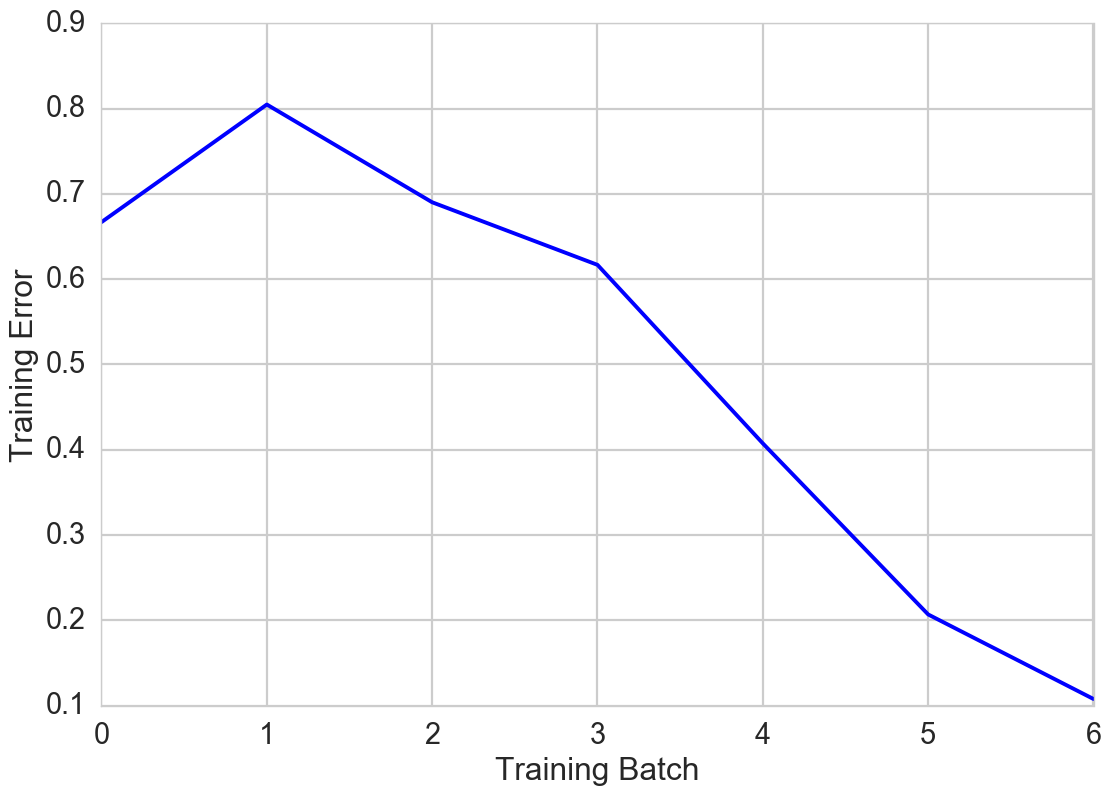

In [624]:
plot(loss_list)
xlabel("Training Batch")
ylabel("Training Error")

# Our test accuracy is very high, we can now stop modeling and start using the network as a CV!

In [511]:
if train :
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        net_out = model(data)
        # sum up batch loss
        test_loss += criterion(net_out, target).data[0]
        pred = net_out.data.max(1)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data).sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))



Test set: Average loss: 0.0023, Accuracy: 212/212 (100%)



# VDE_METADYNAMICS implements some basic code for writing Plumed scripts 

In [495]:
from vde_metadynamics.render_network import *
from vde_metadynamics.render_df import *

# This code block with write our pytoch model as a CV!m

In [625]:
def render_network(model):
    model.dtype = torch.DoubleTensor
    model.use_cuda =False
    model.cpu()
    model.double()
    output =[]
    index = 0
    for ind,i in enumerate([model.input_layer, model.hidden_network,model.output_layer]):

        if ind in [0,2]:
            for lp in i:
                index += 1
                if str(lp).startswith("Linear"):
                    output.append(render_fc_layer(index, lp))
                elif str(lp).startswith("Sigmoid"):
                    output.append(render_sigmoid_layer(index, lp,hidden_size=model.hidden_size))
                elif str(lp).startswith("Swish"):
                    output.append(render_swish_layer(index, lp,hidden_size=model.hidden_size))
                elif str(lp).startswith("Dropout"):
                    print("Dropout layer found, ignoring it")
                    #if model.dropout_rate ==0:
                    index -= 1
                    continue
                elif str(lp).startswith("z_mean") or str(lp).startswith("z_log_var"):
                    print("Lambda layer found, ignoring it")
                    index -= 1
                    continue
                else:
                    raise ValueError("Only Linear and Sigmoid Layers are supported for now")
        elif ind==1:
            for j in i:
                for lp in j:
                    print(index)
                    index += 1
                    print(lp,index)
                    if str(lp).startswith("Linear"):
                        output.append(render_fc_layer(index, lp))
                    elif str(lp).startswith("Sigmoid"):
                        output.append(render_sigmoid_layer(index, lp,hidden_size=model.hidden_size))
                    elif str(lp).startswith("Swish"):
                        output.append(render_swish_layer(index, lp,hidden_size=model.hidden_size))
                    elif str(lp).startswith("Dropout"):
                        print("Dropout layer found, ignoring it")
                        #if model.dropout_rate ==0:
                        index -= 1
                        continue
                    elif str(lp).startswith("z_mean") or str(lp).startswith("z_log_var"):
                        print("Lambda layer found, ignoring it")
                        index -= 1
                        continue
                    else:
                        raise ValueError("Only Linear and Sigmoid Layers are supported for now")
        else:
            raise ValueError("Something is wrong")

    return ''.join(output)

In [626]:
all_out=[]
# Add the restart
all_out.append("RESTART\n")
# Convert the raw dihedrals into something plumed can understand
all_out.extend(render_df(df,output_label_prefix="l"))
# Convert the clf model into something Plumed can understand
all_out.extend(render_network(model))


2
Linear (5 -> 5) 3
3
Swish (
  (sigmoid): Sigmoid ()
) 4
4
Linear (5 -> 5) 5
5
Swish (
  (sigmoid): Sigmoid ()
) 6
6
Linear (5 -> 5) 7
7
Swish (
  (sigmoid): Sigmoid ()
) 8


# Here is the full network!

In [628]:
print("".join(all_out))

RESTART
TORSION ATOMS=5,7,9,15 LABEL=phi_0_1 

TORSION ATOMS=7,9,15,17 LABEL=psi_1_2 

MATHEVAL ARG=phi_0_1 FUNC=sin(x) LABEL=l0_0 PERIODIC=NO 

MATHEVAL ARG=phi_0_1 FUNC=cos(x) LABEL=l0_1 PERIODIC=NO 

MATHEVAL ARG=psi_1_2 FUNC=sin(x) LABEL=l0_2 PERIODIC=NO 

MATHEVAL ARG=psi_1_2 FUNC=cos(x) LABEL=l0_3 PERIODIC=NO 

COMBINE LABEL=l1_0nb ARG=l0_0,l0_1,l0_2,l0_3 COEFFICIENTS=0.21490430447174252,0.988863137483249,0.08842316508054102,0.3986706666274614 PERIODIC=NO 
MATHEVAL ARG=l1_0nb FUNC=x+0.4734514319114862 LABEL=l1_0 PERIODIC=NO 
COMBINE LABEL=l1_1nb ARG=l0_0,l0_1,l0_2,l0_3 COEFFICIENTS=-0.8947953422440964,-0.8803055656173292,0.5752609843783527,-0.7849801760557386 PERIODIC=NO 
MATHEVAL ARG=l1_1nb FUNC=x+0.591028816094881 LABEL=l1_1 PERIODIC=NO 
COMBINE LABEL=l1_2nb ARG=l0_0,l0_1,l0_2,l0_3 COEFFICIENTS=0.012574489684312962,-0.7474300282180829,-0.30974825656115496,-0.02857394963568803 PERIODIC=NO 
MATHEVAL ARG=l1_2nb FUNC=x+-0.8090008083080829 LABEL=l1_2 PERIODIC=NO 
COMBINE LABEL=l1_3n

In [ ]:
# You

In [499]:
import mdtraj as md 
from msmbuilder.featurizer import DihedralFeaturizer

# Lets examine the decision boundary 

/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


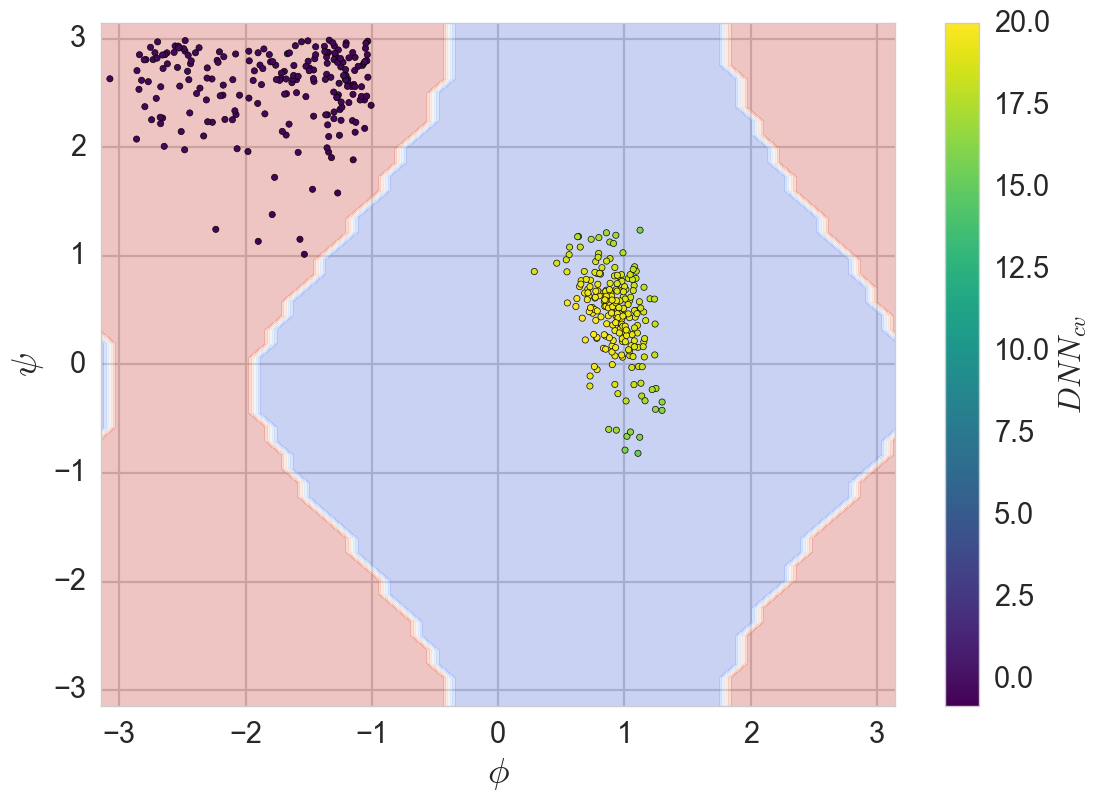

In [629]:
nx =ny=50
lim_x = lim_y = np.linspace(-pi,pi,nx)
xv, yv = np.meshgrid(lim_x, lim_y, sparse=False, indexing='ij')
res = []
test_feat =[]
for i in range(nx):
    for j in range(ny):
        test_feat.extend(np.array([np.sin(xv[i,j]),np.cos(xv[i,j]), np.sin(yv[i,j]), np.cos(yv[i,j])]).reshape(1,-1))

res = model(Variable(torch.from_numpy(np.array(test_feat))).double())
res = torch.max(res,dim=1)[1].data.tolist()

#contourf(lim_x,lim_y,np.array(res).reshape(10,10),cmap='coolwarm')
contourf(lim_x,lim_y,np.array(res).reshape(nx,ny).T,cmap="coolwarm",alpha=0.3)
p=scatter(np.vstack(plot_feat)[:,0],np.vstack(plot_feat)[:,1],
       c=outputs.data[:,0].tolist(),cmap='viridis')
xlim([-pi,pi])
ylim([-pi,pi])
cb=colorbar(p)
cb.set_label(r'$DNN_{cv}$')
ylabel(r'$\psi$',size=26)
xlabel(r'$\phi$',size=26)


# Now we can run some Metadynamics or Umbrella sampling on these CVs

In [558]:
import mdtraj as md
from msmbuilder.featurizer import DihedralFeaturizer

# Load the enhanced sampling trajs 

In [600]:
top = md.load("./0.pdb").remove_solvent()
test_traj = md.load("./dnn_meta_traj//reweight//trajectory.dcd",top=top)
feat = load("./train_data//featurizer.pkl")
bias = np.loadtxt("./dnn_meta_traj/reweight//BIAS")

In [601]:
test_feat = feat.transform([test_traj])[0]
plot_test_feat = DihedralFeaturizer(sincos=False).transform([test_traj])[0]

In [602]:
clf_out =model(Variable(torch.from_numpy(test_feat)).double())[:,0].data.tolist()


# Make sure we implemented the model correctly 

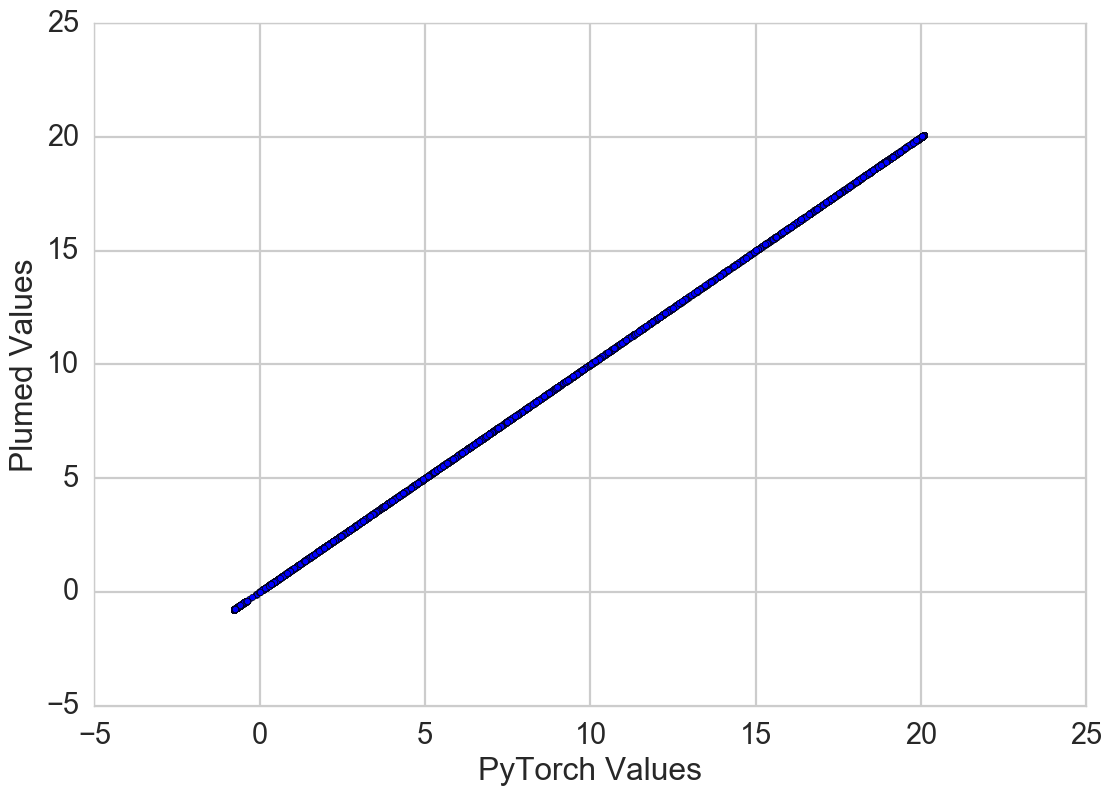

In [603]:
scatter(clf_out,bias[:,1])
xlabel("PyTorch Values")
ylabel("Plumed Values")

# We see many transitions along our slow coordinate ! 

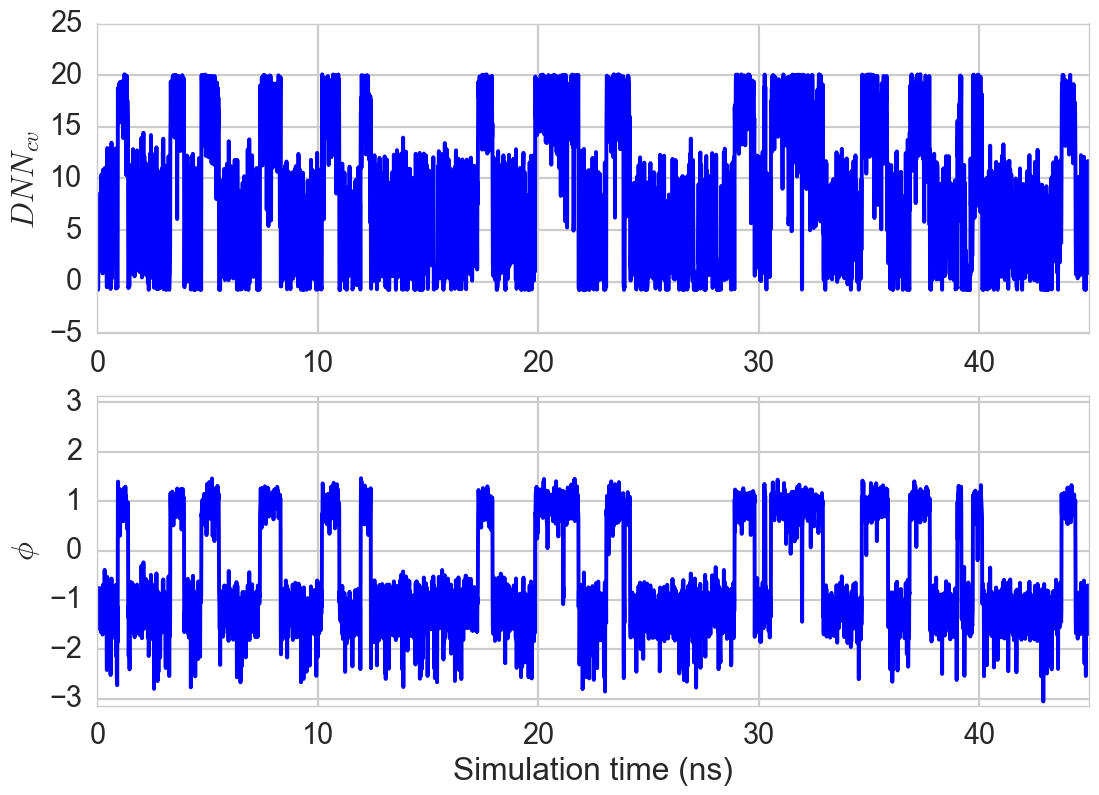

In [604]:
subplot(2,1,1)
plot(bias[:,1])
xticks([0,1000,2000,3000,4000],[0,10,20,30,40])
ylabel(r'$DNN_{cv}$')

subplot(2,1,2)
plot(plot_test_feat[:,0])
xticks([0,1000,2000,3000,4000],[0,10,20,30,40])
xlabel("Simulation time (ns)")
ylim([-pi,pi])
ylabel(r'$\phi$')

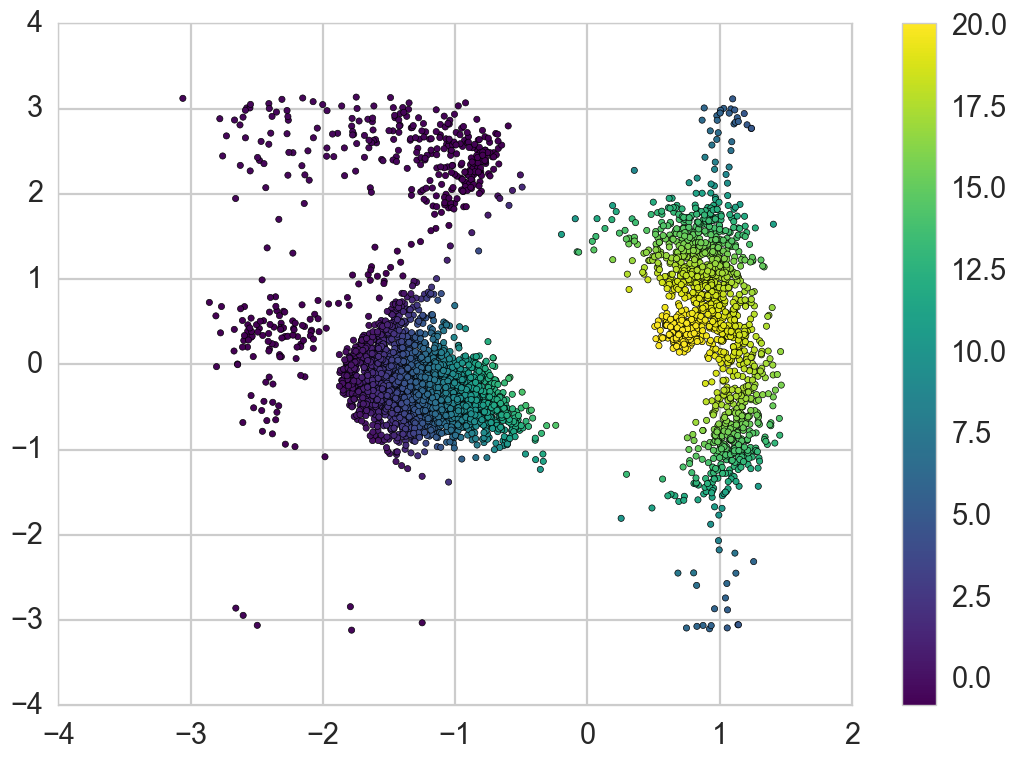

In [605]:
scatter(plot_test_feat[:,0],plot_test_feat[:,1],c=clf_out,cmap='viridis')
colorbar()

In [632]:
# We can use Tiwaray's estimator for more re-weighting. 

/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


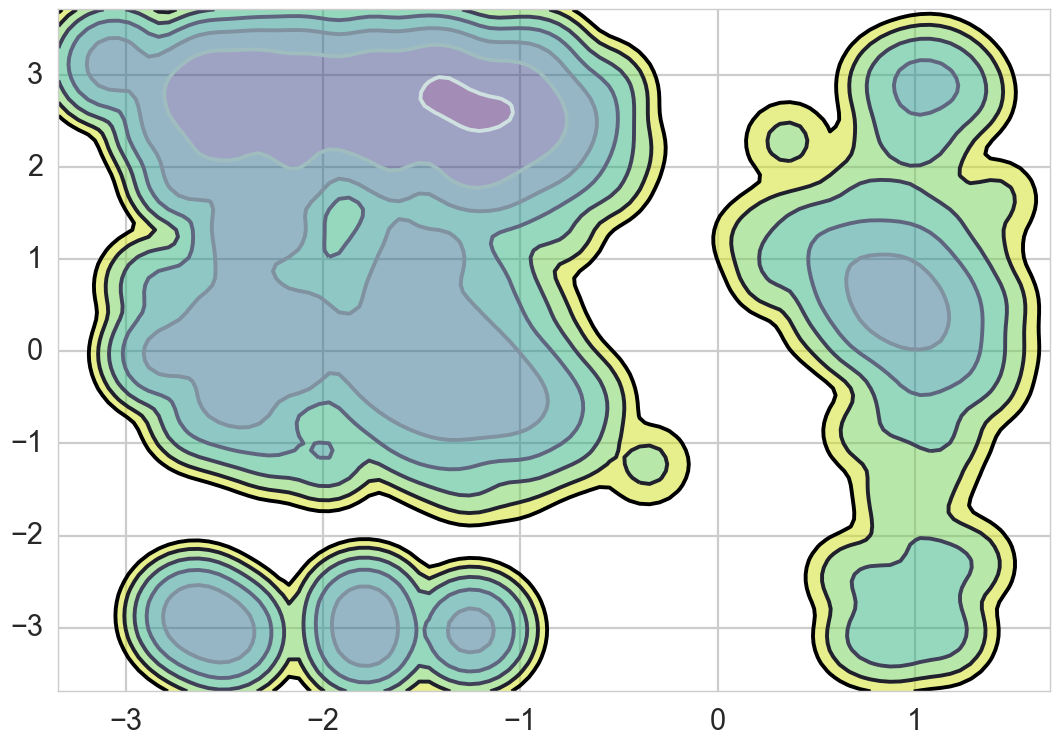

In [606]:
ax,data=msme.plot_free_energy(plot_test_feat,obs=[0,1],n_samples=100000,pi=np.exp(bias[:,-1]/2.49),
                      cmap='viridis',gridsize=100,vmin=-1,vmax=7,n_levels=8,return_data=True)

/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/muneeb/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(-3.141592653589793, 3.141592653589793)

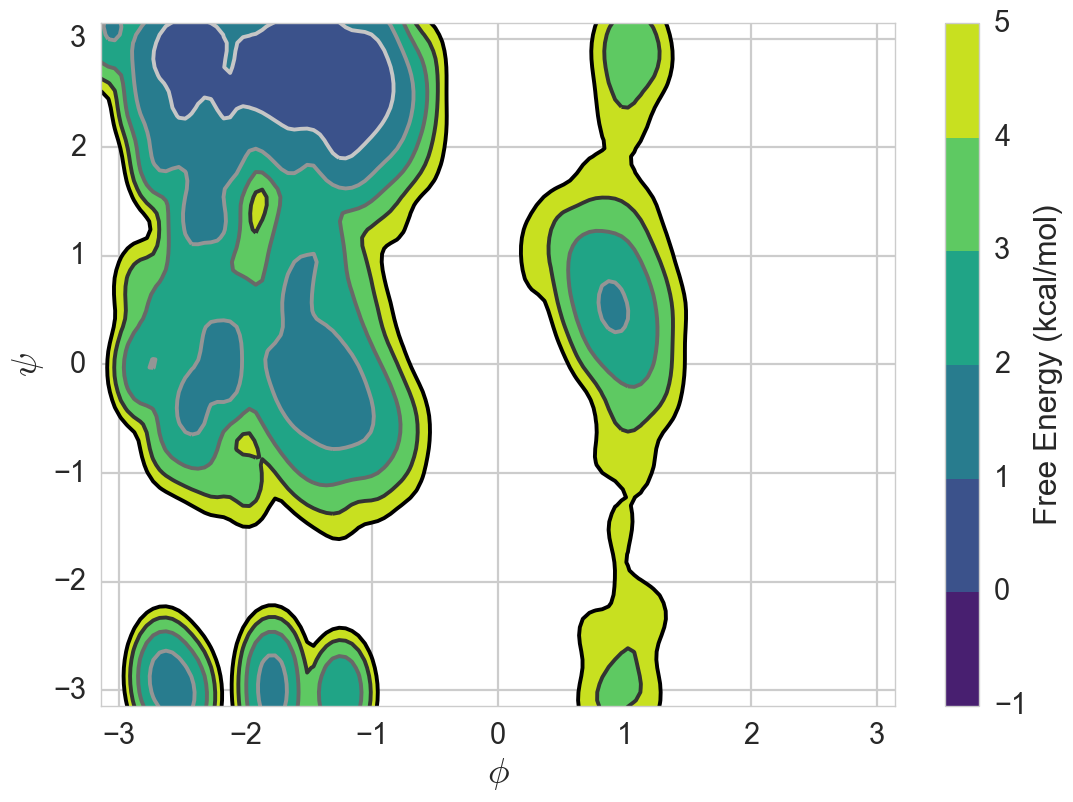

In [608]:

offset = data[2].min(0)
contour(data[0],data[1],data[2],levels=np.linspace(-1,5,7))
p=contourf(data[0],data[1],data[2],levels=np.linspace(-1,5,7),cmap='viridis')
cb=colorbar(p)
cb.set_label("Free Energy (kcal/mol)")
xlabel(r'$\phi$',size=26)
ylabel(r'$\psi$',size=26)
xlim([-pi,pi])
ylim([-pi,pi])


In [582]:
print(model)

BasicClf (
  (input_layer): Sequential (
    (0): Linear (4 -> 5)
    (1): Swish (
      (sigmoid): Sigmoid ()
    )
  )
  (hidden_network): Sequential (
    (0): Sequential (
      (0): Linear (5 -> 5)
      (1): Swish (
        (sigmoid): Sigmoid ()
      )
    )
    (1): Sequential (
      (0): Linear (5 -> 5)
      (1): Swish (
        (sigmoid): Sigmoid ()
      )
    )
    (2): Sequential (
      (0): Linear (5 -> 5)
      (1): Swish (
        (sigmoid): Sigmoid ()
      )
    )
  )
  (output_layer): Sequential (
    (0): Linear (5 -> 2)
  )
)
